In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

# Data processing and manipulation techniques

## Cross-correlation, convolution and matched-filtering

In this lecture we want to explore the problem of identifying the presence of a known signal in well-understood noise. This problem has had applications in many areas of science (starting with radio communications) for a long time.

Let's start illustrating the question we want to ask. Consider that we are looking for a particular signal. This signal might be a little complicated, but we do know exactly what it will look like:

Text(0, 0.5, 'Signal')

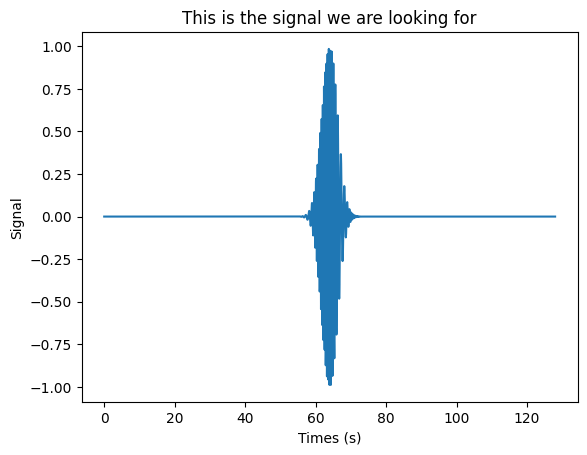

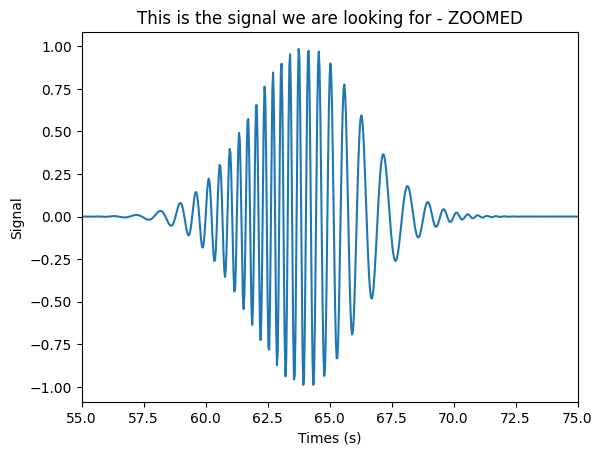

In [2]:
num_data_samples = 4096
sample_rate = 32
times = np.arange(num_data_samples) / sample_rate

gaussian_width = 5
signal_inst_frequency = 2. + 1.0*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)

sinusoid = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
#print(len(sinusoid),len(gaussian))
signal = sinusoid * gaussian

plt.figure()
plt.title("This is the signal we are looking for")
plt.plot(times, signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

plt.figure()
plt.title("This is the signal we are looking for - ZOOMED")
plt.plot(times, signal)
plt.xlim([55,75])
plt.xlabel('Times (s)')
plt.ylabel('Signal')

However, there is also noise present in the dataset. In this case we just consider "white Gaussian noise", which is a very typical assumption. This kind of noise is a Gaussian random variable at each point in time, and there's no correlation between different times. The Fourier transform has equal power at all frequencies.

So let's add noise on top of our signal. You can see the presence of the signal, but without the noiseless example it might not be so clear that there's a signal in here!

Text(0, 0.5, 'Noise + signal')

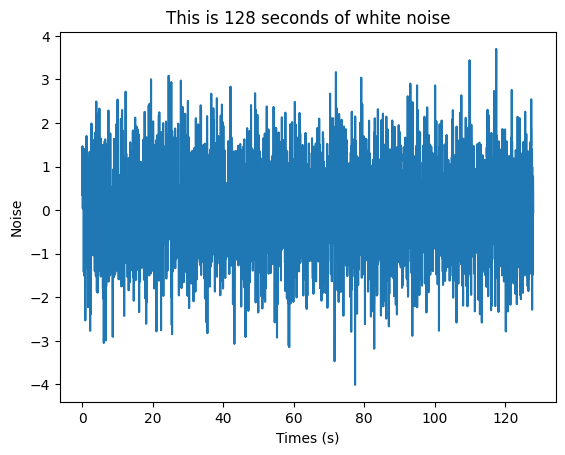

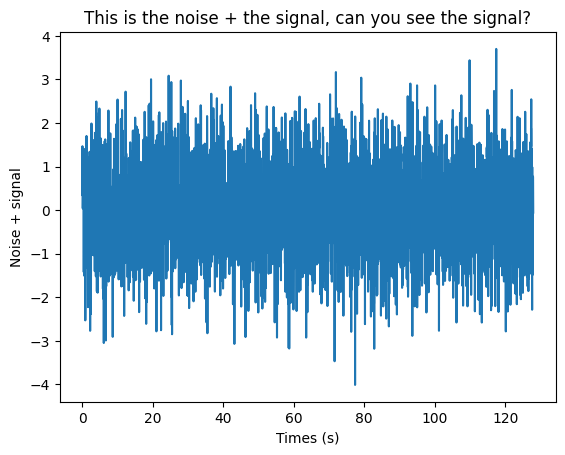

In [3]:
noise = np.random.normal(size=[num_data_samples])
plt.figure()
plt.title("This is 128 seconds of white noise")
plt.plot(times, noise)
plt.xlabel('Times (s)')
plt.ylabel('Noise')

data = signal + noise

plt.figure()
plt.title("This is the noise + the signal, can you see the signal?")
plt.plot(times, data)
plt.xlabel('Times (s)')
plt.ylabel('Noise + signal')



So how would we know there's a signal present in the noise? We can just multiply the data with the expected signal and take the sum.

So if $s$ is the signal and $n$ is the noise and $d$ is the data, such that $d = s + n$. All of these are vectors so can be written as $s_i , d_i, n_i$, where $i$ is the index of the signal/data/noise.

If we multiply $d$ by $s$, we get

$$\sum_i d_i s_i = \sum_i (n_i + s_i) s_i = \sum_i n_i  s_i + \sum_j s_j s_j$$

Looking at these two terms, $\sum_i n_i s_i$ has an expectation value of 0 (as $n_i$ is just random white noise). It will have a non-zero variance, and this becomes our noise term, or the "confusion" making it hard to detect any potential signal.

$\sum_j s_j s_j$ will be non-zero and will have a constant value related to the amplitude of the signal. If $\sum_j s_j s_j$ is larger than the standard deviation of $\sum_i n_i  s_i$ we can start to confidently detect $s_i$ in the data.

This is called "cross-correlating" the data against the expected signal. The math works out the same regardless of the amplitude we assume for our expected signal ... so we don't need to know how loud our signal will be (although quieter signals will be harder to extract). A standard approach here is to choose the amplitude of the expected signal such that the expected variance of $\sum_i n_i  s_i$ will be 1. In this way $\sum_i d_i s_i$ becomes a signal-to-noise ratio!

Let's compute $\sum_i d_i s_i$ and $\sum_i n_i  s_i$ for our datasets.

In [4]:
print("Cross correlation of data and signal:", (data * signal).sum())
print("Cross correlation of noise and signal:", abs((noise * signal).sum()))

Cross correlation of data and signal: 59.58943831053029
Cross correlation of noise and signal: 3.823798469500516


With a signal present we get a value around 60. A number this large will occur only *extremely* rarely if no signal is present ... We'll discuss significance in the next lecture. For now we can demonstrate that this is extremely rare in noise alone by generating a hundred thousand different noisy datasets and seeing what the largest value that we get for this multiplication is.

In [5]:
max_sum = 0
for i in range(100000):
    curr_noise = np.random.normal(size=[num_data_samples])
    current_sum = (curr_noise * signal).sum()
    if abs(current_sum) > max_sum:
        max_sum = abs(current_sum)

print("Largest value was", max_sum, "still much less than 60.")



Largest value was 37.70403306147292 still much less than 60.


Alternatively we can normalize our signal by dividing by $\sqrt{\sum_j s_j s_j}$.

In [8]:
# The normalization must be the square-root of the cross-correlation
norm_value = ((signal * signal).sum())**0.5
# Normalize the signal
template = signal / norm_value
# Then this should be 1
print("Should be 1", ((template * template).sum()))

print("Cross correlation of data and normalized signal:", (data * template).sum())
print("Cross correlation of noise and normalized signal:", abs((noise * template).sum()))

Should be 1 1.0000000000000002
Cross correlation of data and normalized signal: 7.483061786483803
Cross correlation of noise and normalized signal: 0.4801810692898931


Note a bug here - the code above was multiplied by `signal`, not `template`. This has been fixed above.

And again we can simulate 100000 realizations of this noise and see what the distribution of this cross-correlation is:

Largest value was 4.547282128907079 still much less than 8.


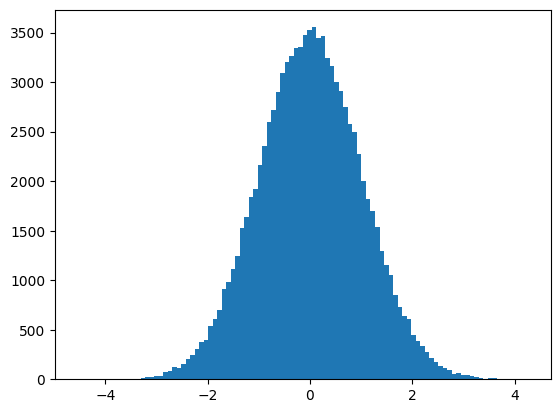

In [11]:
vals = []
max_sum = 0
for i in range(100000):
    curr_noise = np.random.normal(size=[num_data_samples])
    current_sum = (curr_noise * template).sum()
    vals.append(current_sum)
    if abs(current_sum) > max_sum:
        max_sum = abs(current_sum)
        vals.append(current_sum)

print("Largest value was", max_sum, "still much less than 8.")
_,_,_, = plt.hist(vals, bins=100)

This is a Gaussian distribution with mean 0 and variance 1. A value of close to 8 is extremely unlikely here, and so we can confidently extract the signal we added to this noise!

## Exercise 1.1: Calculating the cross-correlation as a function of time

In our previous example we knew where the signal was in the time-series. However, in many applications we do not know if a signal is present, and we would not know where it is present in the data stream.

Here the task is to compute the "cross-correlation" between the signal and our noisy data stream as a function of time. This should be done in a number of steps

* Cut the signal vector so that it is 32 seconds long (512 samples) centered on the peak of the signal, which occurs at 64 seconds.
* Plot the reduced signal
* This 32-second long signal can then be multiplied, and the result summed, with any 32-second long stretch of the data. Choose a random 32-second long stretch of the data and do this.
* Choose the 32-second stretch of data centered on 64 seconds, where the signal is, and do this again.
* Calculate the summed muliplication between the signal and data as a function of time. That is multiply `template` by `data[i:i+(len(template))]` with `i` varying to cover the full length of the data.
* Plot this as a function of time. Can you see the real signal stand out?

512

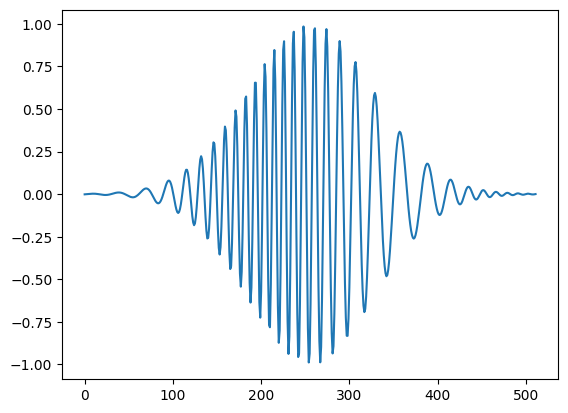

In [16]:
# Note - I think the intent is for the signal to be 16 seconds, not 32.
template = signal[(64-8)*sample_rate:(64+8)*sample_rate]
plt.plot(template)
len(template)

In [17]:
result = [sum(template*data[i:i+(len(template))])
            for i in range(len(data)-len(template))]

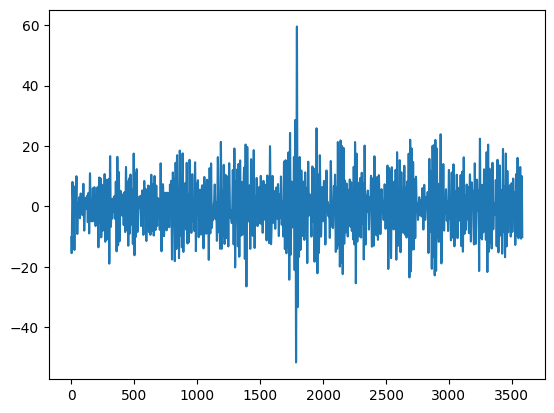

In [18]:
plt.plot(result)

## Exercise 1.2: Finding the signals in the noise

Here are another 4 examples of 4 different signals and corresponding datasets. Can you tell which of these datasets have signals in them, and where in the dataset those signals are?

For each of the signals, add the signal into a 128-second long block of zeroes and try the cross-correlation again (a cross-correlation between a signal and itself is called an "auto-correlation"). This is what you are looking for in the noisy data. How does this change for the different signals and why?

In [19]:
# Let's generate the datasets. DONT CHANGE THIS.
num_data_samples = 4096
sample_rate = 32
times = np.arange(num_data_samples) / sample_rate

gaussian_width = 10
signal_inst_frequency = 2. + 0.*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
signal_1 = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
signal_1 = signal_1 * gaussian
signal_1 = signal_1[48*sample_rate:80*sample_rate]

gaussian_width = 1.
signal_inst_frequency = 2. + 1.*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
signal_2 = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
signal_2 = signal_2 * gaussian
signal_2 = signal_2[48*sample_rate:80*sample_rate]

gaussian_width = 8.
signal_inst_frequency = 2. + 4.*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
signal_3 = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
signal_3 = signal_3 * gaussian
signal_3 = signal_3[48*sample_rate:80*sample_rate]

gaussian_width = 10.
signal_inst_frequency = 2. + 1.*np.sin(2 * np.pi * 0.5 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
signal_4 = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
signal_4 = signal_4 * gaussian
signal_4 = signal_4[48*sample_rate:80*sample_rate]

noise = np.random.normal(size=[num_data_samples])
rndi = np.random.randint(0,sample_rate*96)
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1
noise = np.random.normal(size=[num_data_samples])*0.5
rndi = np.random.randint(0,sample_rate*30)
data_2 = noise
data_2[rndi:rndi+len(signal_2)] += signal_2
rndi = np.random.randint(sample_rate*60,sample_rate*90)
data_2[rndi:rndi+len(signal_2)] += signal_2
noise = np.random.normal(size=[num_data_samples])
rndi = np.random.randint(0,sample_rate*96)
data_3 = noise
data_3[rndi:rndi+len(signal_3)] -= signal_3
noise = np.random.normal(size=[num_data_samples]) * 0.2
rndi = np.random.randint(0,sample_rate*96)
data_4 = noise
data_4[rndi:rndi+len(signal_4)] += signal_4



In [20]:
# SUMMARIZING THE DATA SETS
# DATA SET 1
signal_1 = signal_1
data_1 = data_1

# DATA SET 2
signal_2 = signal_2
data_2 = data_2

# DATA SET 3
signal_3 = signal_3
data_3 = data_3

# DATA SET 4
signal_4 = signal_4
data_4 = data_4


**Soln**: We'll write a function to normalise the template, and to do the correlation, to make things simpler.

In [21]:
def correlate(template, data):
    norm = 1./np.sqrt(np.sum(template*template))
    result = [sum(template*data[i:i+(len(template))])
                for i in range(len(data)-len(template))]
    return norm*np.array(result)

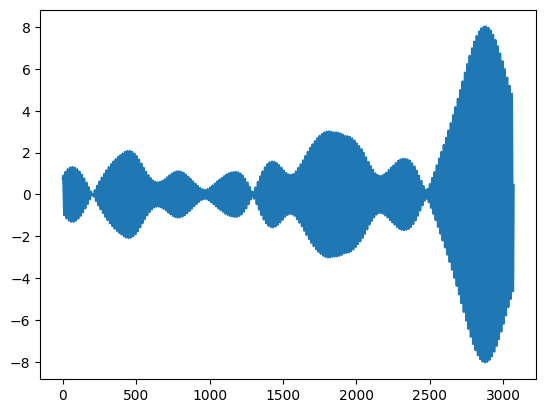

In [31]:
plt.plot(correlate(signal_1, data_1))

**Soln**: Is there a signal here? It's hard to tell.

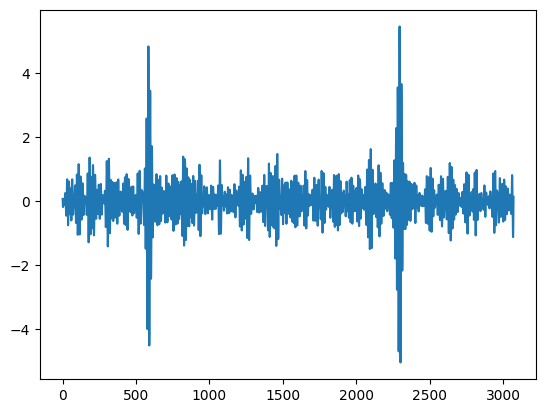

In [32]:
plt.plot(correlate(signal_2, data_2))

**Soln**: Here we have two signals of equal size.

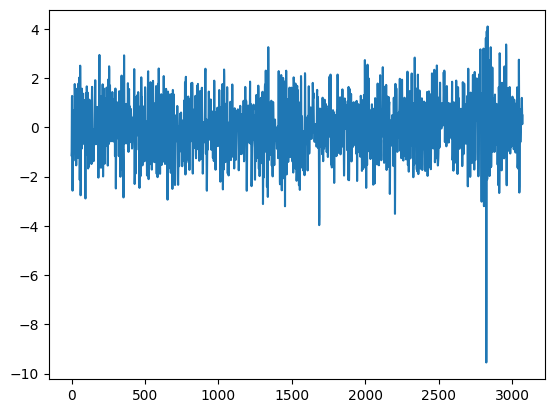

In [33]:
plt.plot(correlate(signal_3, data_3))

**Soln**: Looks like only one signal near the end.

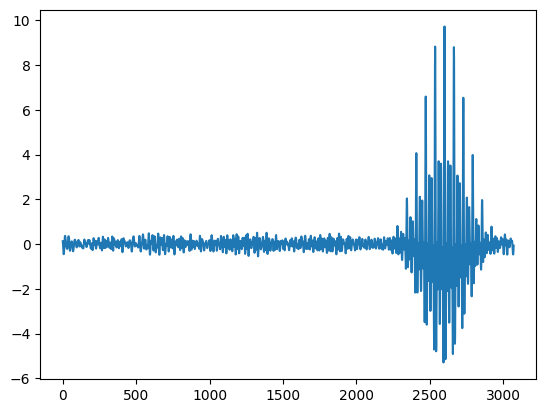

In [34]:
plt.plot(correlate(signal_4, data_4))

**Soln**: This is quite odd. Is it one signal, or many together?

To figure this out, we'll use the autocorrelation as defined above. It will tell us what we expect the shape of the peak caused by a signal to look like.

In [37]:
def autocorrelation(template):
    empty_data = np.zeros(4*len(template))
    # Find where to insert the template so it's in the middle
    idx = (len(empty_data)-len(template))//2
    empty_data[idx:idx+len(template)] = template
    return correlate(template, empty_data)

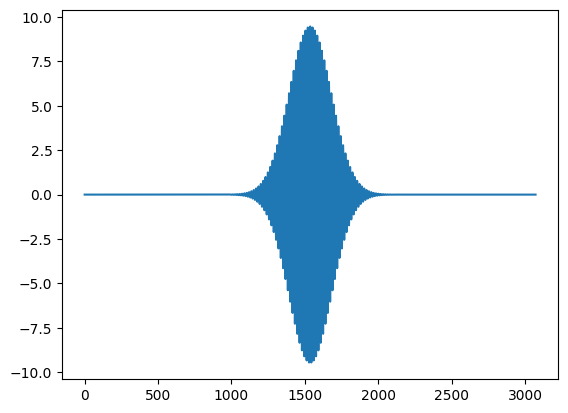

In [38]:
plt.plot(autocorrelation(signal_1))

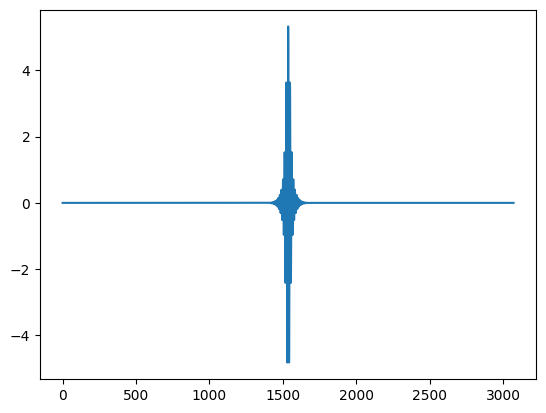

In [39]:
plt.plot(autocorrelation(signal_2))

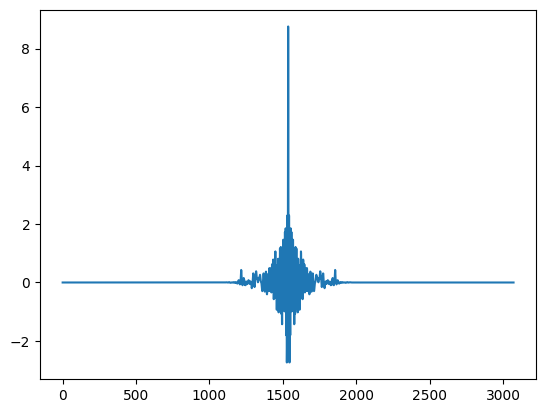

In [40]:
plt.plot(autocorrelation(signal_3))

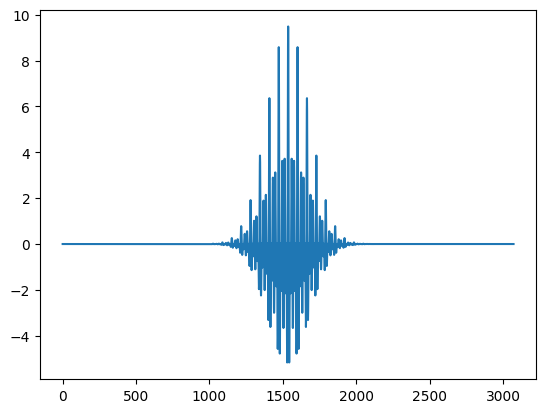

In [41]:
plt.plot(autocorrelation(signal_4))

**Soln**: We see that there was probably one signal in the first data set, right near the end. It looked odd because the autocorrelation is very wide. Likewise, in the fourth data set, there's one signal, but we get multiple spikes because that's what the autocorrelation looks like. Note that the autocorrelation does only have a single peak (which should be true except for very strange signals).

## Exercise 1.3: Which signal is in the noise?

In these four datasets one of the signals is hidden in the noise, but which one?

In [42]:
import random
noise = np.random.normal(size=[num_data_samples])*0.5
rndi = np.random.randint(0,sample_rate*96)
data_11 = noise
data_11[rndi:rndi+len(signal_1)] += random.choice([signal_1, signal_2, signal_3, signal_4])

noise = np.random.normal(size=[num_data_samples])*0.5
rndi = np.random.randint(0,sample_rate*96)
data_12 = noise
data_12[rndi:rndi+len(signal_1)] += random.choice([signal_1, signal_2, signal_3, signal_4])

noise = np.random.normal(size=[num_data_samples])*0.5
rndi = np.random.randint(0,sample_rate*96)
data_13 = noise
data_13[rndi:rndi+len(signal_1)] += random.choice([signal_1, signal_2, signal_3, signal_4])

noise = np.random.normal(size=[num_data_samples])*0.5
rndi = np.random.randint(0,sample_rate*96)
data_14 = noise
data_14[rndi:rndi+len(signal_1)] += random.choice([signal_1, signal_2, signal_3, signal_4])


In [47]:
def multiplot(data):
    plt.plot(correlate(signal_1, data), label='1')
    plt.plot(correlate(signal_2, data), label='2')
    plt.plot(correlate(signal_3, data), label='3')
    plt.plot(correlate(signal_4, data), label='4')
    plt.legend(loc='lower left')

In [52]:
def maxsnr(data):
    values = (np.max(np.abs(correlate(signal_1, data))),
                np.max(np.abs(correlate(signal_2, data))),
                np.max(np.abs(correlate(signal_3, data))),
                np.max(np.abs(correlate(signal_4, data))))
    return values

(1.351401216009565, 2.2840847380821883, 8.304336211657715, 2.6843062405138363)

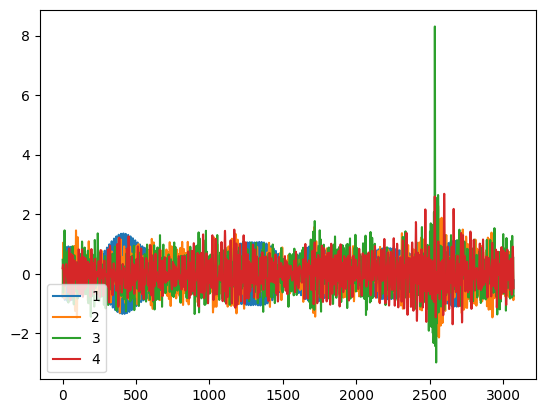

In [53]:
multiplot(data_11)
maxsnr(data_11)

(9.407199701285093, 2.986157642109693, 1.8147703792917256, 2.485122841679723)

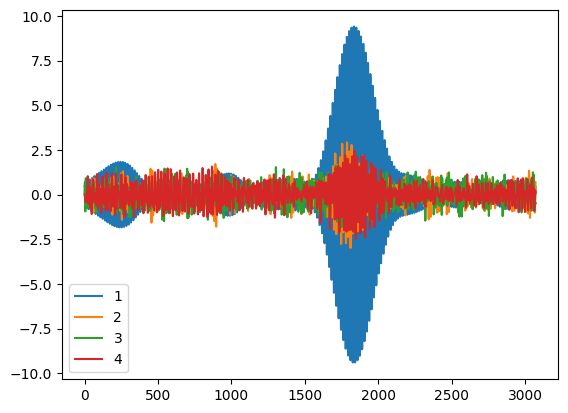

In [54]:
multiplot(data_12)
maxsnr(data_12)

(1.0972646483976645, 2.2930799719267028, 7.750586565267339, 2.3642540177564233)

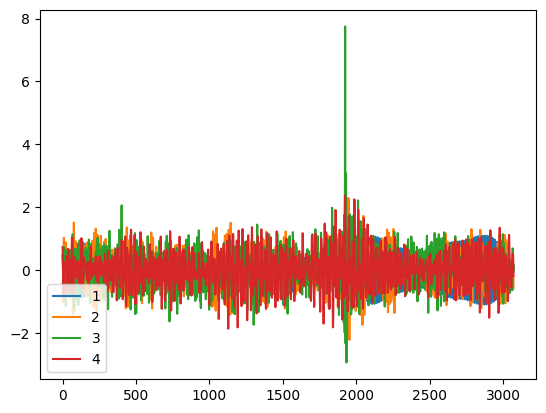

In [55]:
multiplot(data_13)
maxsnr(data_13)

(1.3491006359608375, 2.937679927499727, 9.205776923604562, 2.538023777905966)

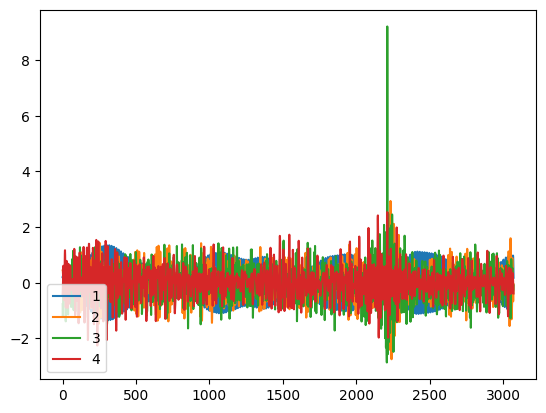

In [56]:
multiplot(data_14)
maxsnr(data_14)

**Soln**: In 1,3, and 4, `signal_3` gives the highest SNR, so that is the signal in the data. In number 2, it's `signal_1`.

## Using Fourier transforms to do cross-correlation quicker (convolution)

We've already mentioned that any time domain operation, such as the cross-correlations here, can be performed in the frequency domain. Let's illustrate this. We start again with our dataset and signal from example 1:

In [57]:
num_data_samples = 4096
sample_rate = 32
times = np.arange(num_data_samples) / sample_rate

gaussian_width = 5
signal_inst_frequency = 2. + 1.0*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)

signal = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
#print(len(signal),len(gaussian))
signal = signal * gaussian

noise = np.random.normal(size=[num_data_samples])*0.5

data = signal + noise


We also define our own Fourier transform code:

**YOU NEED TO ADD A FUNCTION INTO HERE. SEE PREVIOUS NOTEBOOKS. WHAT IS GOOD IF SPEED IS IMPORTANT?**

In [62]:
def compute_fourier_transform(data_time_domain):
    return np.fft.fft(data_time_domain)

def compute_inverse_fourier_transform(data_frequency_domain):
    return np.fft.ifft(data_frequency_domain)


We already saw that we can compute the cross correlation in the time domain:

In [59]:
print("Cross correlation of data and signal:", (data * signal).sum())
print("Cross correlation of noise and signal:", abs((noise * signal).sum()))

Cross correlation of data and signal: 65.29518503580367
Cross correlation of noise and signal: 1.8819482557728509


We can also do the same in the Fourier domain

In [63]:
data_fdomain = compute_fourier_transform(data)
signal_fdomain = compute_fourier_transform(signal)
noise_fdomain = compute_fourier_transform(noise)

# np.conj is the complex conjugate, required to do this operation in frequency domain.
# Also note that we would need to renormalize the signal in the frequency domain if we want
# the cross correlation of noise and signal to follow a Gaussian with unit variance. I use the factor
# of num_data_samples here to get the same number in both cases!
print("Cross correlation of data and signal:", np.real((data_fdomain * np.conj(signal_fdomain)).sum()) / num_data_samples)
print("Cross correlation of noise and signal:", np.real((noise_fdomain * np.conj(signal_fdomain)).sum()) / num_data_samples)

Cross correlation of data and signal: 65.29518503580366
Cross correlation of noise and signal: 1.8819482557728495


What's the benefit of this? Aren't we just putting in more effort to get the same number?

Indeed, if we are only computing one value, we don't need to worry about the Fourier domain, but if we want to compute the cross-correlation, *at many time points* it can be quicker. Remember that in the time domain, we simply had to compute the cross-correlation again and again for every time point? However, in the frequency domain a time-shift can be represented by $e^{i\pi f t}$ ... This is itself an \[inverse\] Fourier transform. Therefore we can quickly compute the cross correlation as a function of time by putting a Fourier transform into this:

The values at t=0 should be the same as above: 65.29518503580366 1.8819482557728502


Text(0.5, 0, 'Times (s)')

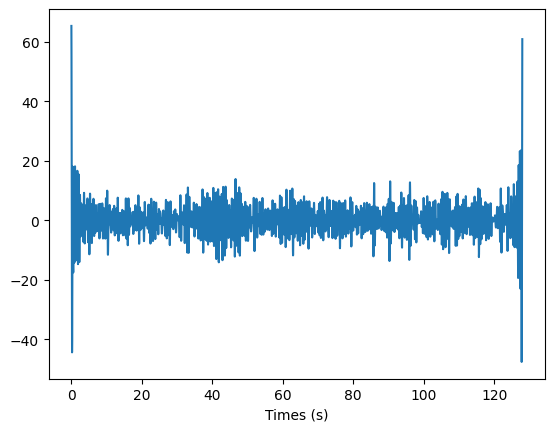

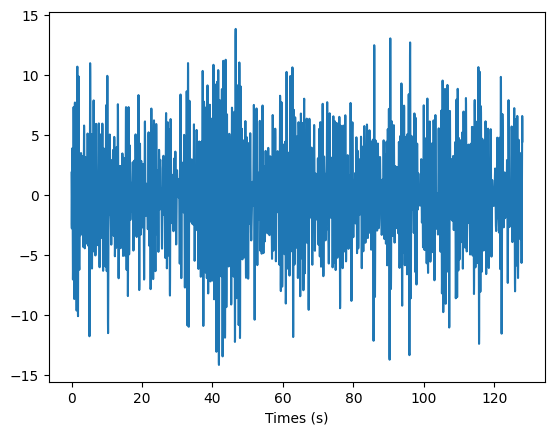

In [64]:
def compute_fdomain_crosscorr(data1, data2):
    multiple_data = data1 * np.conj(data2)
    tdomain_crosscorr = compute_inverse_fourier_transform(multiple_data)
    return np.real(tdomain_crosscorr)


data_signal_crosscorr = compute_fdomain_crosscorr(data_fdomain, signal_fdomain)
noise_signal_crosscorr = compute_fdomain_crosscorr(noise_fdomain, signal_fdomain)

print("The values at t=0 should be the same as above:", data_signal_crosscorr[0], noise_signal_crosscorr[0])

plt.figure()
plt.plot(times, data_signal_crosscorr)
plt.xlabel('Times (s)')

plt.figure()
plt.plot(times, noise_signal_crosscorr)
plt.xlabel('Times (s)')


This is a much quicker way of computing a cross-correlation at multiple times. However, there are a number of subtleties here. Lets deal with them one-by-one.

* Why is the peak of the cross-correlation at t=0, when the signal was in the middle?

The answer to that is that the signal we cross-correlated with did not have its peak at t=0 and so the obtained plot above is offset in time. Or in technical terms this is not a "zero-phase" filter. To correct this we need to put the peak of the waveform at the start. REMEMBER: In the frequency domain time series wrap around so that the start is connected to the end:

Text(0.5, 0, 'Times (s)')

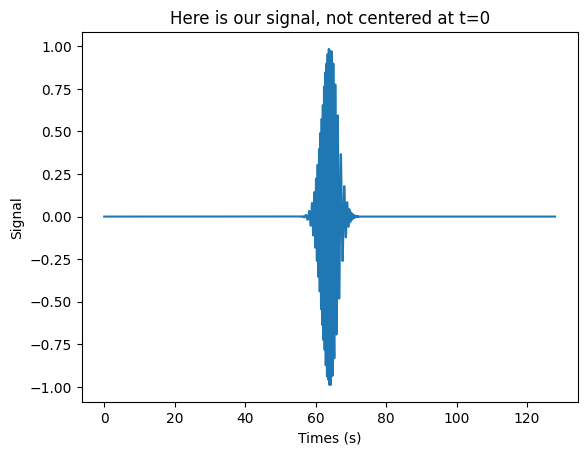

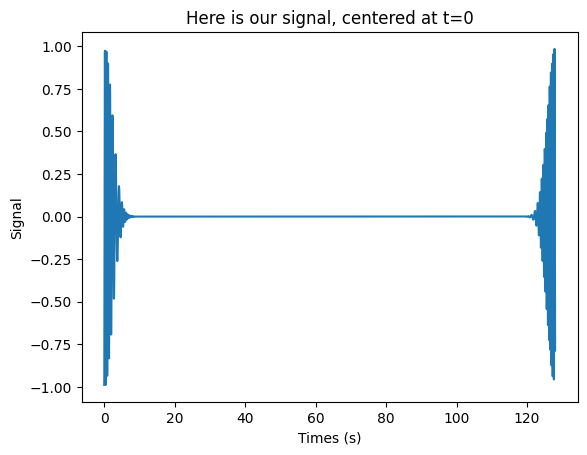

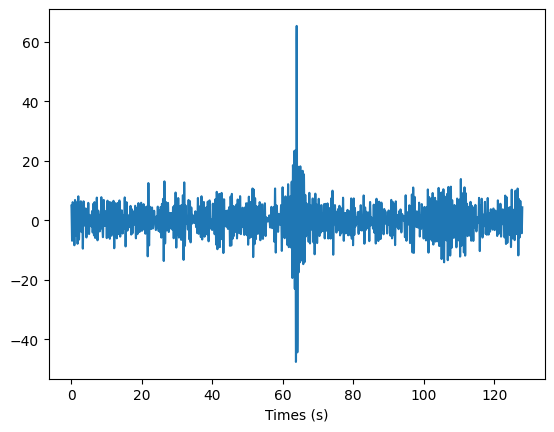

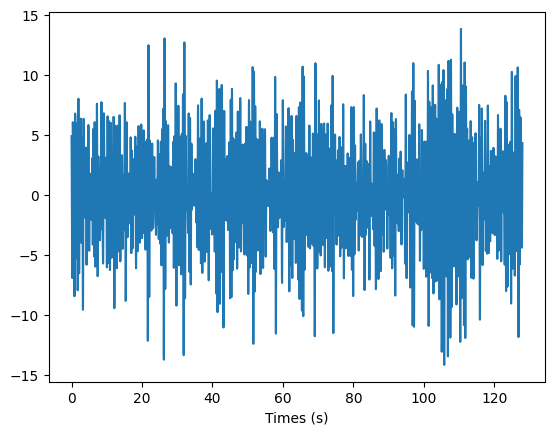

In [65]:
plt.figure()
plt.title("Here is our signal, not centered at t=0")
plt.plot(times, signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

# Identify peak of the signal
max_time = np.argmax(abs(signal))
# And shift the signal
shifted_signal = np.roll(signal, -max_time)

plt.figure()
plt.title("Here is our signal, centered at t=0")
plt.plot(times, shifted_signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

# And Fourier transform
shifted_signal_fdomain = compute_fourier_transform(shifted_signal)

# And cross-correlate again:
data_signal_crosscorr = compute_fdomain_crosscorr(data_fdomain, shifted_signal_fdomain)
noise_signal_crosscorr = compute_fdomain_crosscorr(noise_fdomain, shifted_signal_fdomain)

plt.figure()
plt.plot(times, data_signal_crosscorr)
plt.xlabel('Times (s)')

plt.figure()
plt.plot(times, noise_signal_crosscorr)
plt.xlabel('Times (s)')



Okay, so now the peak in our time series is in the same place as the signal. Let's worry about the next concern:

* The length of the data and the length of the signal waveform must be the same.

In most cases you might be searching for quite a short signal in a long stretch of data. There's two ways to deal with this problem:

 1. Perform the cross-correlation repeatedly on short stretches of data, and join these together to get the cross-correlation over the whole data set.
 1. Make the signal waveform longer (by padding with zeroes).

The second solution might be simpler, but it significantly increases the computational cost. In many real-world examples the first approach must be used. This is also linked to our third concern.

* As with our high-pass filter example from before we still assume that the data is cyclical. This can introduce a discontinuity into the data and make the cross-correlation invalid whenever it overlaps this region.

Let's try and illustrate this last problem by using a different data set, where we are not using white noise and the data is not cyclical:

Text(0.5, 0, 'Times (s)')

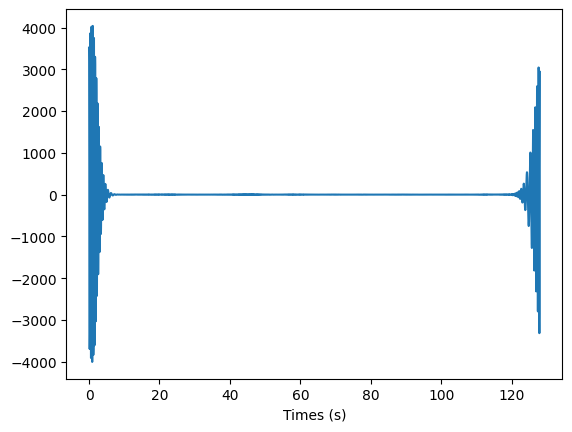

In [66]:
times_4096 = np.arange(4096*32) / 32
data_time_domain_TMP = np.zeros(4096*32)
# Add some narrow range mid-frequency noise
for i in range(4*4096,4*4096+1000):
    omega = i / 4096. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_TMP += 100*np.sin(times_4096 * omega + phase)


low_freq_noise = data_time_domain_TMP[23:4096+23]

low_freq_noise_fdomain = compute_fourier_transform(low_freq_noise)

lf_noise_signal_crosscorr = compute_fdomain_crosscorr(low_freq_noise_fdomain, shifted_signal_fdomain)

plt.figure()
plt.plot(times, lf_noise_signal_crosscorr)
plt.xlabel('Times (s)')


Here we can see huge values of the cross-correlation at both ends. This is where the signal waveform is matched against the join between the end and the start of the data. This is not physical. In this case values at the start and the end should be discarded. The length of data discarded should be equal to the length of the signal waveform.

## Exercise 2.1: Finding the signals in the noise revisited

Here we repeat the previous exercise where you need to locate a specified signal in the noise generated. Except here the noise is quite a bit longer than the signal.

How many signals are in the dataset, and where are they?

In [67]:
# Let's generate the datasets. DONT CHANGE THIS.
num_data_samples = 128 * 128 * 32
sample_rate = 32
times_long = np.arange(num_data_samples) / sample_rate
times_small = np.arange(128*32) / sample_rate

gaussian_width = 10
signal_inst_frequency = 2. + 0.*np.sin(2 * np.pi * 0.1 * times_small)
phases = [0]
for i in range(1,len(times_small)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
signal_1 = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
signal_1 = signal_1 * gaussian
signal_1 = signal_1[48*sample_rate:80*sample_rate]


noise = np.random.normal(size=[num_data_samples])
rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 3

rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 3

rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 3



In [ ]:
# Add code here to determine the location of the signal!
signal_to_find = signal_1
data = data_1

In [68]:
len(signal_1), len(data_1)

(1024, 524288)

In [69]:
def fdomain_correlate(template, data):
    # Normalise the template
    norm = 1./np.sqrt(np.sum(template*template))
    # Pad the template with zeros
    new_template = np.zeros(len(data))
    new_template[:len(template)] = norm*template
    # Shift the template to have its peak at the start
    max_time = np.argmax(abs(new_template))
    new_template = np.roll(new_template, -max_time)

    data_fdomain = compute_fourier_transform(data)
    shifted_template_fdomain = compute_fourier_transform(new_template)

    # Now do the cross-correlation
    return compute_fdomain_crosscorr(data_fdomain, shifted_template_fdomain)

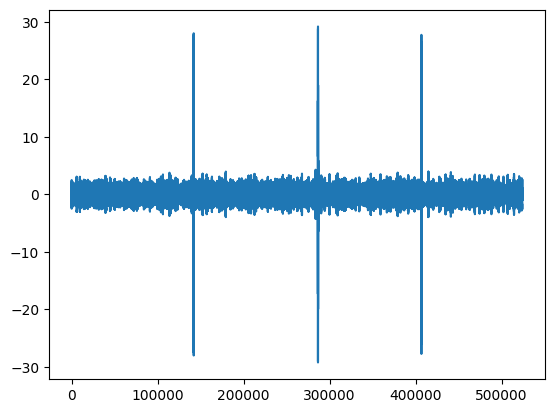

In [70]:
plt.plot(fdomain_correlate(signal_1, data_1))

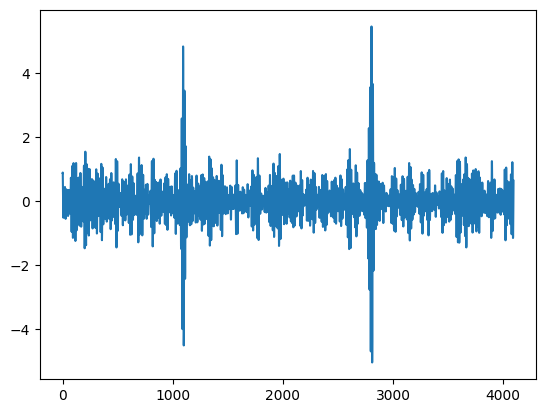

In [71]:
plt.plot(fdomain_correlate(signal_2, data_2))

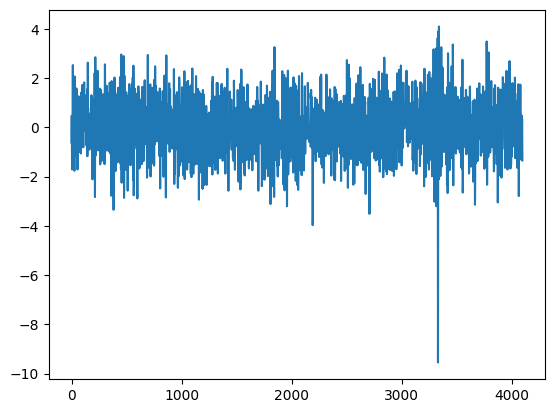

In [72]:
plt.plot(fdomain_correlate(signal_3, data_3))

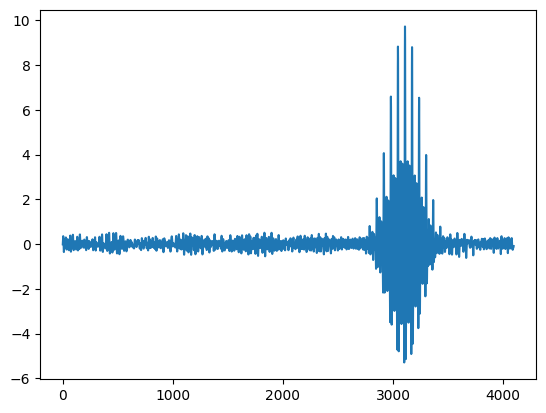

In [73]:
plt.plot(fdomain_correlate(signal_4, data_4))

**Soln**: That's three examples of `signal_1`, two of `signal_2`, and one each of the others.

## Exercise 2.2: Finding the signals in pink noise (challenging)

Let's try exercise 1.4 again, but with one difference. Now instead of trying to find the signal(s) in *white* noise, you'll need to try to find it in *pink* noise.

HINT: To attempt this you will want to whiten the data (see the problem at the end of the second data processing lecture!) However, whitening the data will also change the signal as well, so you will need to also apply your whitening filter to the signal.

This problem is most easily attempted in the frequency-domain.

In [74]:
# Let's generate the datasets. DONT CHANGE THIS.
num_data_samples = 128 * 128 * 32
sample_rate = 32
times_long = np.arange(num_data_samples) / sample_rate
times_small = np.arange(128*32) / sample_rate

gaussian_width = 10
signal_inst_frequency = 0.1
phases = [0]
for i in range(1,len(times_small)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency * 1./sample_rate)
signal_1 = np.sin(phases)
gaussian = np.exp( - (times_small - 64)**2 / (2 * gaussian_width))
signal_1 = signal_1 * gaussian

signal_inst_frequency = 4
phases = [0]
for i in range(1,len(times_small)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency * 1./sample_rate)
signal_1_T = np.sin(phases)
gaussian = np.exp( - (times_small - 64)**2 / (2 * gaussian_width))
signal_1 = signal_1 + signal_1_T * gaussian

signal_1 = signal_1[48*sample_rate:80*sample_rate]

pink_noise_prefactors = 1. / (np.arange(num_data_samples))
# The first entry will go to inf, so remove any DC noise component
pink_noise_prefactors[0] = 0
# Must be symmetric!
for i in range(1, num_data_samples//2):
    pink_noise_prefactors[-i] = pink_noise_prefactors[i]

noise = np.random.normal(size=[num_data_samples])
noise_fdomain = compute_fourier_transform(noise)
noise_fdomain = noise_fdomain * pink_noise_prefactors
noise = compute_inverse_fourier_transform(noise_fdomain).real
rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 0.00003

rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 0.00003

rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 0.00003

rndi = np.random.randint(0,sample_rate*(128*128 - 1))
data_1 = noise
data_1[rndi:rndi+len(signal_1)] += signal_1 * 0.00003



<ipython-input-74-35f0261ca3b2>:26: RuntimeWarning: divide by zero encountered in divide
  pink_noise_prefactors = 1. / (np.arange(num_data_samples))


In [ ]:
# Write code here to find the signal

signal_to_find = signal_1
data = data_1

**Soln**: This is a challenge that you'll also face in Coursework 2. You can see in the code how the noise is generated - this should help you account for it as well.

## SUMMARY

We have learnt how to use cross-correlation to identify signals present in noisy data-streams, and how to use the auto-correlation to understand how the signals will appear. We have also explored how to distinguish between different signals that might be present in a dataset.